In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Demande Europe

In [2]:
df=pd.read_csv("./BEL/2015.csv")

In [3]:
df

,Time (CET/CEST),Day-ahead Total Load Forecast [MW] - BZN|BE,Actual Total Load [MW] - BZN|BE
0,01.01.2015 00:00 - 01.01.2015 00:15,9698.0,10142.0
1,01.01.2015 00:15 - 01.01.2015 00:30,9527.0,10051.0
2,01.01.2015 00:30 - 01.01.2015 00:45,9368.0,9953.0
3,01.01.2015 00:45 - 01.01.2015 01:00,9216.0,9822.0
4,01.01.2015 01:00 - 01.01.2015 01:15,10130.0,9755.0
...,...,...,...
35039,31.12.2015 22:45 - 31.12.2015 23:00,9633.0,9233.0
35040,31.12.2015 23:00 - 31.12.2015 23:15,9701.0,9431.0
35041,31.12.2015 23:15 - 31.12.2015 23:30,9609.0,9383.0
35042,31.12.2015 23:30 - 31.12.2015 23:45,9428.0,9295.0


In [4]:
def read_dem():
    country = ['BEL','FR','DE','LU','NE']
    name = ['BZN|BE','BZN|FR','Germany (DE)','Luxembourg (LU)','BZN|NL']
    col = 'Actual Total Load [MW] - '
    dem = {}
    for year in [2015,2016,2017,2018,2019]:
        #print(year)
        dtot = np.zeros(8736)
        for nc,c in enumerate(country):
            d=[]
            file = pd.read_csv('./'+c+'/'+str(year)+'.csv')
            n = len(file)
            if n >35000:
                a=file[col+name[nc]]
                d=a.loc[a.index%4==0]
            else:
                d=file[col+name[nc]].to_list()
            nbnan = np.sum(np.isnan(np.array(d[:8736])))
            if nbnan>0:
                print(c)
                print(np.argwhere(np.isnan(np.array(d[:8736]))))
            dtot += np.array(d[:8736])
        dem[year]=dtot
    return dem

In [5]:
dem = read_dem()

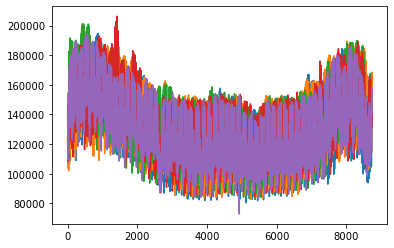

In [6]:
for y in range(2015,2020):
    plt.plot(dem[y])
plt.show()

# Production RES

In [7]:
df=pd.read_csv("./BEL/Gen_2015.csv")

In [8]:
def prod_hydro():
    country = ['BEL','FR','DE','NE']
    cols = ['Hydro Water Reservoir  - Actual Aggregated [MW]','Hydro Pumped Storage  - Actual Aggregated [MW]']
    hy=0
    hp=0
    for y in range(2015,2020):
        for c in country:
            file = pd.read_csv('./'+c+'/Gen_'+str(y)+'.csv').replace("n/e",0).fillna(0).replace('0',0)
            hy += file[cols[0]].sum()
            hp += file[cols[1]].sum()
    return hy/5,hp/5

In [9]:
hy,hp=prod_hydro()
print(hy)
print(hp)

18294902.0
45122412.6


In [10]:
def read_res():
    country = ['BEL','FR','DE','NE']
    cols = ['Wind Offshore  - Actual Aggregated [MW]','Wind Onshore  - Actual Aggregated [MW]',
        'Hydro Run-of-river and poundage  - Actual Aggregated [MW]','Solar  - Actual Aggregated [MW]']
    res = {}
    for year in [2015,2016,2017,2018,2019]:
        restot = np.zeros(8736)
        for nc,c in enumerate(country):
            r=[]
            file = pd.read_csv('./'+c+'/Gen_'+str(year)+'.csv')
            n = len(file)
            if n >35000:
                a=file[cols].T.sum()
                r=a.loc[a.index%4==0]
            else:
                r=file[cols].T.sum().to_list()
            restot += np.array(r[:8736])
        res[year]=restot
    return res

In [11]:
res = read_res()

C:\Users\jujua\AppData\Local\Temp/ipykernel_10604/2993234118.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  r=file[cols].T.sum().to_list()


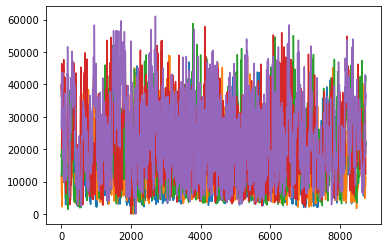

In [12]:
for y in range(2015,2020):
    plt.plot(res[y])
plt.show()

# Scenarios demande residuelle

In [13]:
def index_20scenario():
    choix_demande = []
    for t in range(52):
        scenar_dem = []
        for y in range(2015,2020):
            scenar_dem.append([y,0])
            scenar_dem.append([y,1])
            scenar_dem.append([y,2])
            scenar_dem.append([y,-1])
            scenar_dem.append([y,-2])
        keepindex = np.random.choice(np.arange(25),size=20)
        final_scenar_dem=[]
        for i in range(20):
            final_scenar_dem.append(scenar_dem[keepindex[i]])
        choix_demande.append(final_scenar_dem)
    choix_res = []
    for t in range(52):
        scenar_res = []
        for y in range(2015,2020):
            scenar_res.append([y,0])
            scenar_res.append([y,1])
            scenar_res.append([y,-1])
            scenar_res.append([y,2])
            scenar_res.append([y,-2])
        keepindex = np.random.choice(np.arange(25),size=20)
        final_scenar_res=[]
        for i in range(20):
            final_scenar_res.append(scenar_res[keepindex[i]])
        choix_res.append(final_scenar_res)       
    return choix_demande, choix_res

In [14]:
def build_scenario():
    choix_dem,choix_res = index_20scenario()
    cols = ["Scen. {}".format(i+1) for i in range(20)]
    df_demresi = pd.DataFrame(np.nan, index=[i for i in range(168*52)],columns=cols)
    for i in range(20):
        demande_resi= np.zeros(168*52)
        prod_res = np.zeros(168*52)
        for t in range(52): 
            source_year, add_day = choix_dem[t][i][0], choix_dem[t][i][1]
            source_year_res, add_day_res = choix_res[t][i][0], choix_res[t][i][1]
            source_dem = dem[source_year]
            source_res = res[source_year_res]
            for h in range(168):
                date = 168*t+h+24*add_day
                if 0 <= date and date < len(source_dem)-1:
                    a = source_dem[date]
                else:
                    a = source_dem[168*t+h]
                date = 168*t+h+24*add_day_res
                if  0<= date and date< len(source_res)-1:
                    b = source_res[date]
                else:
                    b = source_res[168*t+h]
                demande_resi[168*t+h] = a-b
        df_demresi["Scen. {}".format(i+1)] = demande_resi
    return df_demresi

In [15]:
demresi = build_scenario()

In [16]:
demresi

,Scen. 1,Scen. 2,Scen. 3,Scen. 4,Scen. 5,Scen. 6,Scen. 7,Scen. 8,Scen. 9,Scen. 10,Scen. 11,Scen. 12,Scen. 13,Scen. 14,Scen. 15,Scen. 16,Scen. 17,Scen. 18,Scen. 19,Scen. 20
0,105003.0,107963.0,100541.0,82614.0,106042.0,100708.0,127153.0,117934.0,107230.0,107046.0,125893.0,101104.0,121816.0,132531.0,124228.0,107963.0,132493.0,104552.0,112643.0,97286.0
1,100942.0,103460.0,93629.0,80565.0,100510.0,94936.0,120543.0,112936.0,99815.0,101356.0,123704.0,96848.0,115979.0,129327.0,115438.0,103460.0,130162.0,101109.0,107513.0,89277.0
2,96584.0,98410.0,89183.0,76336.0,96455.0,89245.0,115411.0,107664.0,95191.0,98800.0,120445.0,91580.0,112515.0,125027.0,110528.0,98410.0,126393.0,96723.0,104525.0,84532.0
3,91711.0,92074.0,85289.0,71490.0,92064.0,83162.0,110269.0,100593.0,90995.0,96545.0,115062.0,86186.0,109684.0,119089.0,106265.0,92074.0,121000.0,91781.0,101799.0,80758.0
4,90114.0,87938.0,85049.0,70148.0,90459.0,77963.0,109081.0,94827.0,88794.0,97949.0,111386.0,81967.0,110524.0,115344.0,103875.0,87938.0,117343.0,88815.0,102696.0,81119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,146581.0,136086.0,147575.0,125201.0,143804.0,134749.0,144332.0,147575.0,138958.0,152919.0,131604.0,108322.0,137135.0,140263.0,147575.0,131646.0,120101.0,152550.0,153251.0,127214.0
8732,145615.0,134769.0,146090.0,123181.0,142353.0,133845.0,145685.0,146090.0,140754.0,152403.0,130203.0,107879.0,134481.0,138099.0,146090.0,132763.0,117269.0,150144.0,149972.0,124870.0
8733,139216.0,128602.0,139835.0,116051.0,135582.0,127459.0,140114.0,139835.0,136214.0,146011.0,122585.0,103294.0,127439.0,131299.0,139835.0,127678.0,109298.0,140996.0,142096.0,117039.0
8734,131314.0,121938.0,132531.0,107965.0,128989.0,119198.0,133885.0,132531.0,130635.0,138559.0,114767.0,97488.0,119500.0,123589.0,132531.0,121693.0,100673.0,132652.0,133768.0,109481.0


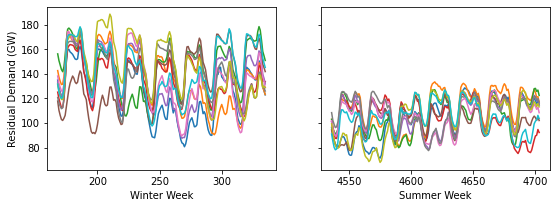

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
for i in range(1,20,2):
    axs[0].plot(demresi['Scen. %s'%i].iloc[168:336]/1e3)
    axs[1].plot(demresi['Scen. %s'%i].iloc[27*168:28*168]/1e3)
axs[0].set_ylabel("Residual Demand (GW)")
axs[0].set_xlabel("Winter Week")
axs[1].set_xlabel("Summer Week")
plt.show()


In [136]:
demresi.to_csv("scenarios_demande_residuelle.csv")

# Analyse échanges UK et Espagne

In [15]:
cols = ['BZN|GB > BZN|FR Total [MW]','BZN|FR > BZN|GB Total [MW]','BZN|ES > BZN|FR Total [MW]','BZN|FR > BZN|ES Total [MW]']
impuk=[]
impes=[]
expuk=[]
expes=[]
for y in range(2017,2023):
    df = pd.read_csv('./UK/'+str(y)+'.csv').fillna(0)
    impuk += df[cols[0]].to_list()
    expuk += df[cols[1]].to_list()
    df = pd.read_csv('./Spain/'+str(y)+'.csv').fillna(0)
    impes += df[cols[2]].to_list()
    expes += df[cols[3]].to_list()

In [19]:
netimportsuk = np.array(impuk)-np.array(expuk)
netimportses = np.array(impes)-np.array(expes)

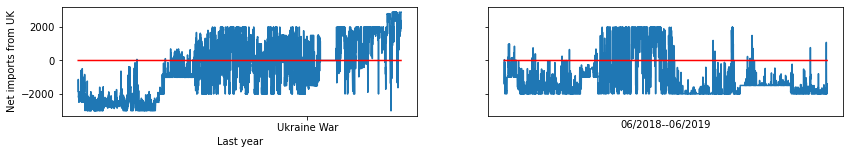

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14,2), sharey=True)
axs[0].plot(netimportsuk[-8736:])
axs[0].plot(np.zeros(len(netimportsuk[-8736:])),color='red')
axs[1].plot(netimportsuk[-5*8736:-4*8736])
axs[1].plot(np.zeros(len(netimportsuk[-5*8736:-4*8736])),color='red')

axs[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].set_ylabel("Net imports from UK")
axs[0].set_xlabel("Last year")
axs[0].set_xticks([8736-2533])
axs[0].set_xticklabels(['Ukraine War'])
axs[1].set_xlabel("06/2018--06/2019")
plt.show()

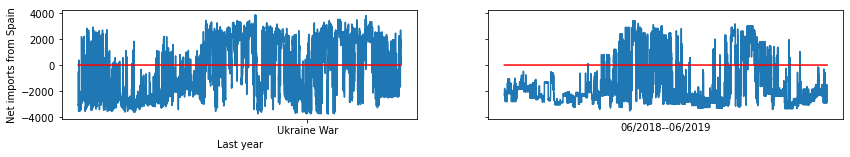

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14,2), sharey=True)
axs[0].plot(netimportses[-8736:])
axs[0].plot(np.zeros(len(netimportses[-8736:])),color='red')
axs[1].plot(netimportses[-5*8736:-4*8736])
axs[1].plot(np.zeros(len(netimportses[-5*8736:-4*8736])),color='red')

axs[1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].set_ylabel("Net imports from Spain")
axs[0].set_xlabel("Last year")
axs[0].set_xticks([8736-2533])
axs[0].set_xticklabels(['Ukraine War'])
axs[1].set_xlabel("06/2018--06/2019")
plt.show()

# Interconnexions déterministes

### FR-Suisse

In [18]:
frsu = pd.read_csv("./IntercoFRSui/2019.csv")
frsu[['BZN|CH > BZN|FR Total [MW]','BZN|FR > BZN|CH Total [MW]']]

,BZN|CH > BZN|FR Total [MW],BZN|FR > BZN|CH Total [MW]
0,293.0,2580.0
1,314.0,2666.0
2,438.0,2774.0
3,281.0,2865.0
4,160.0,2913.0
...,...,...
8756,1195.0,2212.0
8757,411.0,2655.0
8758,104.0,2713.0
8759,569.0,2698.0


In [19]:
cols = ['BZN|CH > BZN|FR Total [MW]','BZN|FR > BZN|CH Total [MW]']
def readfrsu():
    imp = np.zeros(8736)
    exp = np.zeros(8736)
    for y in range(2016,2020):
        file = pd.read_csv("./IntercoFRSui/"+str(y)+".csv")
        imp += 1/4*np.array(file[cols[0]].to_list())[:8736]
        exp += 1/4*np.array(file[cols[1]].to_list())[:8736]
    return imp,exp


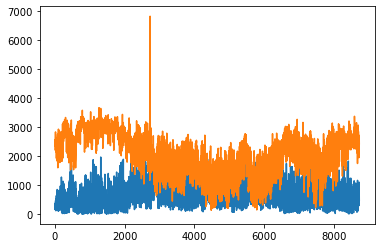

In [20]:
impFRSU,expFRSU=readfrsu()
plt.plot(impFRSU)
plt.plot(expFRSU)
plt.show()

### DE PL

In [21]:
df = pd.read_csv("./IntercoDEPL/2016.csv")

In [22]:
deb = pd.read_csv("./IntercoDEPL/2018_deb.csv")
fin = pd.read_csv("./IntercoDEPL/2018_fin.csv")
imp = np.zeros(8736)
exp = np.zeros(8736)
for i in range(8736):
    if i<=6553:
        imp[i] = deb['BZN|PL > BZN|DE-AT-LU Total [MW]'].iloc[i]
        exp[i] = deb['BZN|DE-AT-LU > BZN|PL Total [MW]'].iloc[i]
    else:
        imp[i] = fin['BZN|PL > BZN|DE-LU Total [MW]'].iloc[i]
        exp[i] = fin['BZN|DE-LU > BZN|PL Total [MW]'].iloc[i]

In [23]:
impDEPL = imp+np.array(pd.read_csv("./IntercoDEPL/2016.csv")['BZN|PL > BZN|DE-AT-LU Total [MW]'].to_list())[:8736]+np.array(pd.read_csv("./IntercoDEPL/2017.csv")['BZN|PL > BZN|DE-AT-LU Total [MW]'].to_list())[:8736]+np.array(pd.read_csv("./IntercoDEPL/2019.csv")['BZN|PL > BZN|DE-LU Total [MW]'].to_list())[:8736]
expDEPL = exp+np.array(pd.read_csv("./IntercoDEPL/2016.csv")['BZN|DE-AT-LU > BZN|PL Total [MW]'].to_list())[:8736]+np.array(pd.read_csv("./IntercoDEPL/2017.csv")['BZN|DE-AT-LU > BZN|PL Total [MW]'].to_list())[:8736]+np.array(pd.read_csv("./IntercoDEPL/2019.csv")['BZN|DE-LU > BZN|PL Total [MW]'].to_list())[:8736]
impDEPL *=0.25
expDEPL *=0.25

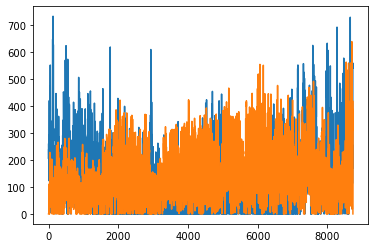

In [24]:
plt.plot(impDEPL)
plt.plot(expDEPL)
plt.show()

### DE-Lu Suisse

In [25]:
df= pd.read_csv('./IntercoDELUSui/2019.csv')
df

,Time (CET/CEST),BZN|CH > BZN|DE-LU Day Ahead [MW],BZN|CH > BZN|DE-LU Total [MW],BZN|DE-LU > BZN|CH Day Ahead [MW],BZN|DE-LU > BZN|CH Total [MW]
0,01.01.2019 00:00 - 01.01.2019 01:00,0.0,0.0,800.0,800.0
1,01.01.2019 01:00 - 01.01.2019 02:00,1.0,1.0,801.0,801.0
2,01.01.2019 02:00 - 01.01.2019 03:00,0.0,0.0,800.0,800.0
3,01.01.2019 03:00 - 01.01.2019 04:00,0.0,0.0,800.0,800.0
4,01.01.2019 04:00 - 01.01.2019 05:00,0.0,0.0,800.0,800.0
...,...,...,...,...,...
8756,31.12.2019 19:00 - 31.12.2019 20:00,164.0,233.0,607.0,640.0
8757,31.12.2019 20:00 - 31.12.2019 21:00,200.0,210.0,700.0,1004.0
8758,31.12.2019 21:00 - 31.12.2019 22:00,64.0,316.0,711.0,767.0
8759,31.12.2019 22:00 - 31.12.2019 23:00,1.0,173.0,636.0,969.0


In [26]:
impDELUSU=np.array(pd.read_csv('./IntercoDELUSui/2019.csv')['BZN|CH > BZN|DE-LU Total [MW]'])[:8736]+np.array(pd.read_csv('./IntercoDELUSui/2021.csv')['BZN|CH > BZN|DE-LU Total [MW]'])[:8736]
impDELUSU*=0.5
expDELUSU=np.array(pd.read_csv('./IntercoDELUSui/2019.csv')['BZN|DE-LU > BZN|CH Total [MW]'])[:8736]+np.array(pd.read_csv('./IntercoDELUSui/2021.csv')['BZN|DE-LU > BZN|CH Total [MW]'])[:8736]
expDELUSU*=0.5

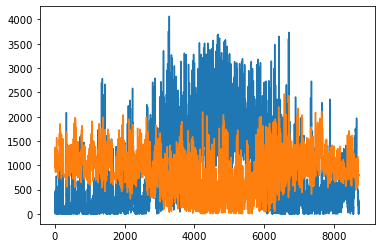

In [27]:
plt.plot(impDELUSU)
plt.plot(expDELUSU)
plt.show()

### DE - AT

In [28]:
impDEAT=np.array(pd.read_csv('./IntercoDEAT/2019.csv')['BZN|AT > BZN|DE-LU Total [MW]'])[:8736]+np.array(pd.read_csv('./IntercoDEAT/2021.csv')['BZN|AT > BZN|DE-LU Total [MW]'])[:8736]
impDEAT*=0.5
expDEAT=np.array(pd.read_csv('./IntercoDEAT/2019.csv')['BZN|DE-LU > BZN|AT Total [MW]'])[:8736]+np.array(pd.read_csv('./IntercoDEAT/2021.csv')['BZN|DE-LU > BZN|AT Total [MW]'])[:8736]
expDEAT*=0.5

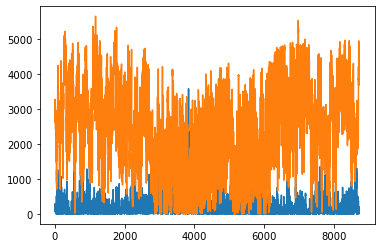

In [29]:
plt.plot(impDEAT)
plt.plot(expDEAT)
plt.show()

### Total

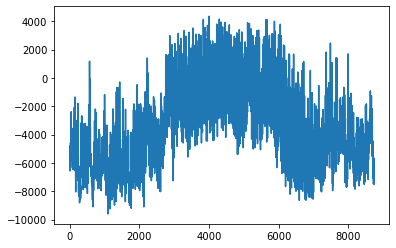

In [30]:
totimp = impFRSU+impDEPL+impDELUSU+impDEAT
totexp = expFRSU+expDEPL+expDELUSU+expDEAT
plt.plot(totimp-totexp)
plt.show()

In [31]:
imports = pd.DataFrame(totimp)
imports.to_csv('importsATSUPL.csv')
exports = pd.DataFrame(totexp)
exports.to_csv('exportsATSUPL.csv')
netimports = pd.DataFrame(totimp-totexp)
netimports.to_csv('net_importsATSUPL.csv')